In [9]:
#Importing necessary libraries
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from PIL import Image, ImageChops, ImageEnhance
from sklearn.utils import shuffle
import tensorflow as tf
import random
from keras.models import load_model
import keras.backend as K

In [2]:
au_path = 'CASIA2\Au'
tp_path = 'CASIA2\Tp'

au_data = {'image_id': [],'image_path': [],'label': []}
tp_data = {'image_id': [],'image_path': [],'label': []}

for img in os.listdir(au_path):
    if img.endswith('jpg') or img.endswith('png'):
        temp_path = os.path.join(au_path, img)
        au_data['image_id'].append(img.split("_")[2].split('.')[0])
        au_data['image_path'].append(temp_path)
        au_data['label'].append('real')

for img in os.listdir(tp_path):
    if img.endswith('jpg') or img.endswith('png'):
        temp_path = os.path.join(tp_path, img)
        tp_data['image_path'].append(temp_path)
        tp_data['label'].append('fake')
        tp_data['image_id'].append(img.split('_')[7].split('.')[0])
    
    
        
au_data = pd.DataFrame(au_data)
tp_data = pd.DataFrame(tp_data)

casia_data = pd.concat([au_data, tp_data], ignore_index=True)
casia_data = casia_data.sample(frac=1, random_state=random.seed(42)).reset_index(drop=True)
casia_data.head()

image_id                                         image_path label
0    11386  CASIA2\Tp\Tp_D_NRN_S_N_cha00031_pla00020_11386...  fake
1    30097                         CASIA2\Au\Au_arc_30097.jpg  real
2    11997  CASIA2\Tp\Tp_D_NRN_M_N_nat10147_nat00097_11997...  fake
3    30004                         CASIA2\Au\Au_sec_30004.jpg  real
4    30470                         CASIA2\Au\Au_pla_30470.jpg  real

In [3]:
tp_path = 'CASIA2\Tp'
gt_path = 'CASIA2\CASIA 2 Groundtruth'

tp_data = {'image_id': [],'image_path': [],'label': []}
gt_data = {'image_id': [],'mask_image_path': []}


for img in os.listdir(tp_path):
    if img.endswith('jpg') or img.endswith('png'):
        temp_path = os.path.join(tp_path, img)
        tp_data['image_path'].append(temp_path)
        tp_data['label'].append('fake')
        tp_data['image_id'].append(img[:-4])
    
for img in os.listdir(gt_path):
    temp_path = os.path.join(gt_path, img)
    gt_data['mask_image_path'].append(temp_path)
    gt_data['image_id'].append(img[:-7])
    
        
tp_data = pd.DataFrame(tp_data)
gt_data = pd.DataFrame(gt_data)

casia_data = pd.merge(tp_data, gt_data, on='image_id')
casia_data = casia_data.sample(frac=1, random_state=random.seed(42)).reset_index(drop=True)
casia_data.head()

image_id  \
0  Tp_S_CNN_M_N_txt00086_txt00086_11312   
1  Tp_S_NNN_S_N_ind00094_ind00094_10654   
2  Tp_S_CRD_S_N_ind00050_ind00050_10898   
3  Tp_D_NNN_M_B_nat00086_nat00097_11284   
4  Tp_D_NRN_M_N_art10113_cha10110_11561   

                                          image_path label  \
0  CASIA2\Tp\Tp_S_CNN_M_N_txt00086_txt00086_11312...  fake   
1  CASIA2\Tp\Tp_S_NNN_S_N_ind00094_ind00094_10654...  fake   
2  CASIA2\Tp\Tp_S_CRD_S_N_ind00050_ind00050_10898...  fake   
3  CASIA2\Tp\Tp_D_NNN_M_B_nat00086_nat00097_11284...  fake   
4  CASIA2\Tp\Tp_D_NRN_M_N_art10113_cha10110_11561...  fake   

                                     mask_image_path  
0  CASIA2\CASIA 2 Groundtruth\Tp_S_CNN_M_N_txt000...  
1  CASIA2\CASIA 2 Groundtruth\Tp_S_NNN_S_N_ind000...  
2  CASIA2\CASIA 2 Groundtruth\Tp_S_CRD_S_N_ind000...  
3  CASIA2\CASIA 2 Groundtruth\Tp_D_NNN_M_B_nat000...  
4  CASIA2\CASIA 2 Groundtruth\Tp_D_NRN_M_N_art101...

In [4]:

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

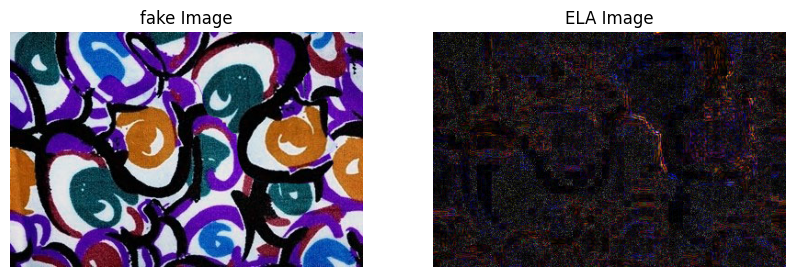

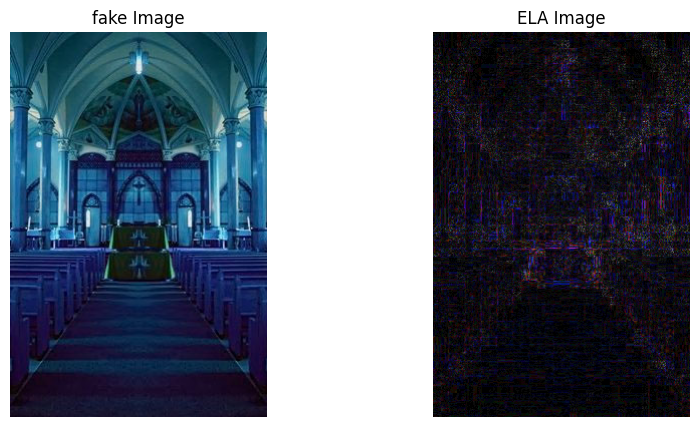

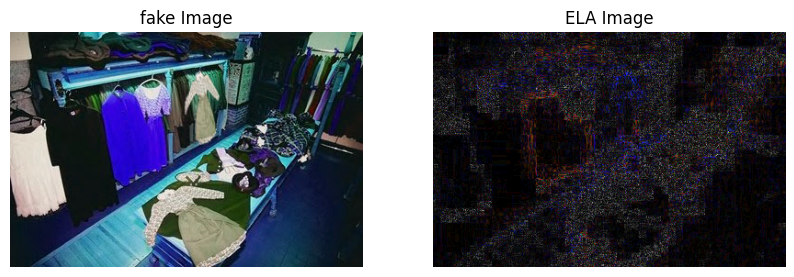

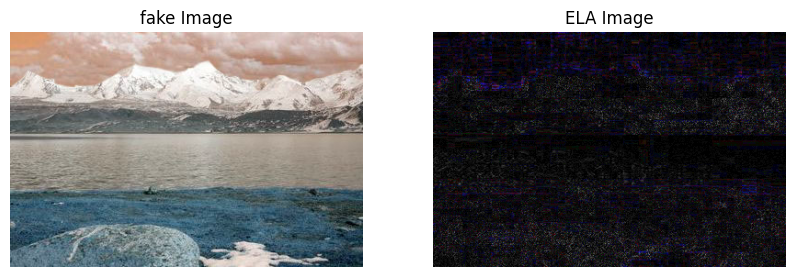

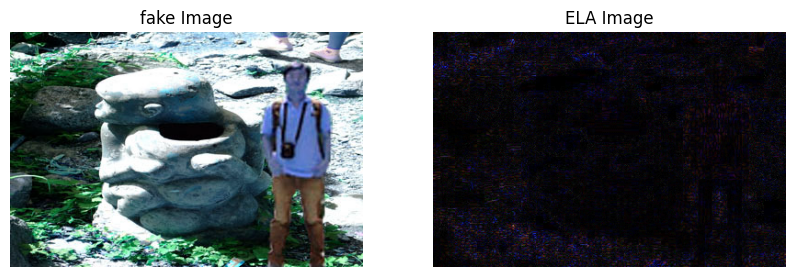

In [5]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd

num_samples_to_visualize = 5

for i in range(num_samples_to_visualize):
    # Get image paths
    original_img_path = casia_data.loc[i, 'image_path']
    ela_img = convert_to_ela_image(original_img_path,85)

    # Read images
    original_img = cv2.imread(original_img_path)
    label = casia_data.loc[i, 'label']

    # Plot the images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f'{label} Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(ela_img)
    plt.title('ELA Image')
    plt.axis('off')

    plt.show()


In [6]:
q = [4.0, 12.0, 2.0]
filter1 = [[0, 0, 0, 0, 0],
           [0, -1, 2, -1, 0],
           [0, 2, -4, 2, 0],
           [0, -1, 2, -1, 0],
           [0, 0, 0, 0, 0]]
filter2 = [[-1, 2, -2, 2, -1],
           [2, -6, 8, -6, 2],
           [-2, 8, -12, 8, -2],
           [2, -6, 8, -6, 2],
           [-1, 2, -2, 2, -1]]
filter3 = [[0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 1, -2, 1, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0]]


filter1 = np.asarray(filter1, dtype=float) / q[0]
filter2 = np.asarray(filter2, dtype=float) / q[1]
filter3 = np.asarray(filter3, dtype=float) / q[2]
    
filters = filter1+filter2+filter3

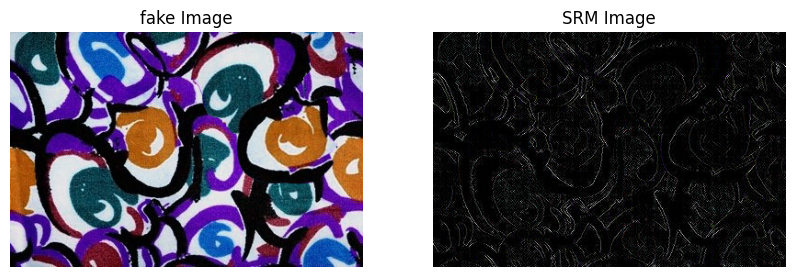

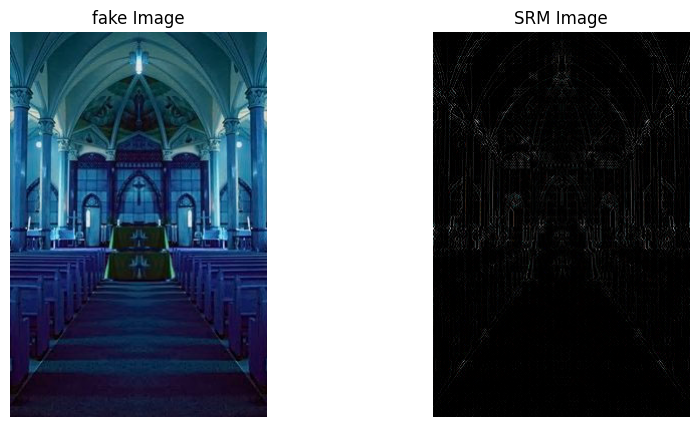

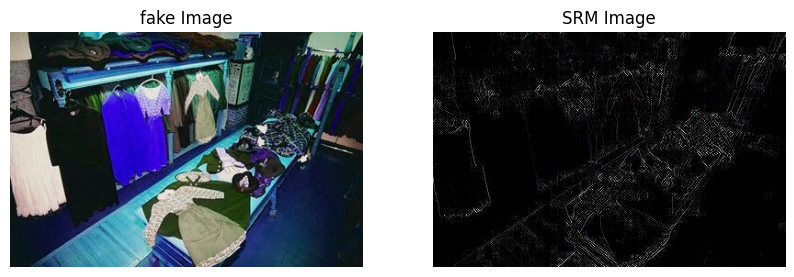

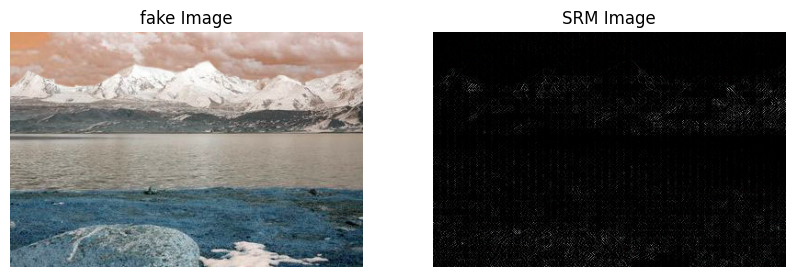

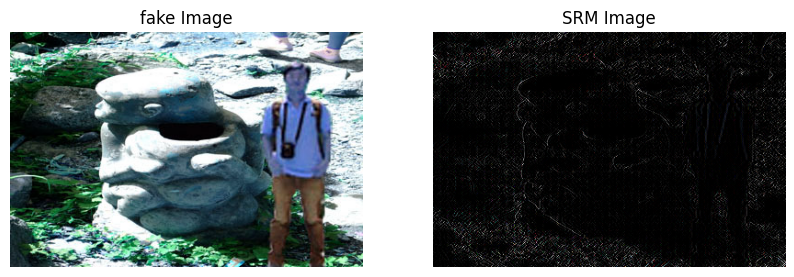

In [7]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd

num_samples_to_visualize = 5

for i in range(num_samples_to_visualize):
    # Get image paths
    original_img_path = casia_data.loc[i, 'image_path']

    # Read images
    original_img = cv2.imread(original_img_path)
    label = casia_data.loc[i, 'label']
    preprocess_img=cv2.filter2D(original_img,-1,filters)

    # Plot the images
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f'{label} Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(preprocess_img)
    plt.title('SRM Image')
    plt.axis('off')

    plt.show()


In [8]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0

In [10]:
#IoU Score
def iou_score(y_true, y_pred, smooth=1e-5):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou
    
#Load model 
phase1 = load_model("phase1.h5")
phase2 = load_model('phase2.h5', custom_objects={'iou_score': iou_score})

In [13]:
# Mask Image Preprocessing

def change_pixel_value(A) :
    if len(A.shape)==3 :
        A=A[:,:,0]
    #Intilize a array B 
    B=np.zeros((A.shape[0],A.shape[1]))
    for i in range(A.shape[0]) :
        for j in range(A.shape[1]) :
            if A[i][j]==255 :
                B[i][j]=0.0 
            else :
                B[i][j]=1.0
    return B

In [14]:
def predictRegion(img):
    img = cv2.imread(img)
    img = cv2.resize(img, (512, 512))
    srm_img = cv2.filter2D(img, -1, filters)
    
    img = np.expand_dims(img, axis=0)
    srm_img = np.expand_dims(srm_img, axis=0)

    prediction = phase2.predict([img, srm_img])

    prediction = prediction.squeeze()

    for i in range(prediction.shape[0]) :
        for j in range(prediction.shape[1]) :
            if prediction[i][j]>0.75 :
                prediction[i][j]=0.0
            else :
                prediction[i][j]=1.0

    return prediction

In [15]:
def predict(img_path) :
    pi=prepare_image(img_path)
    pi=pi.reshape(1,128,128,3)
    predict=phase1.predict(pi)
    return predict

1/1 [==============================] - 1s 696ms/step


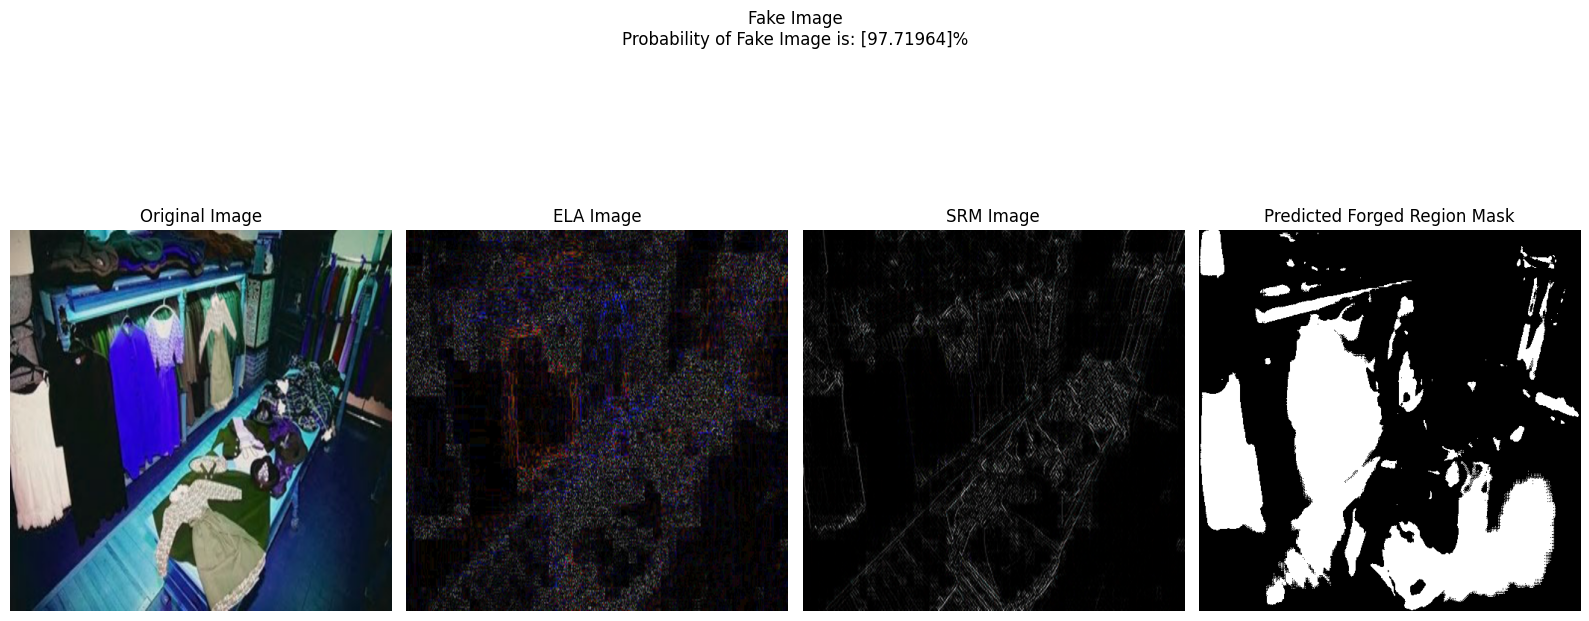

In [22]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image

plt.figure(figsize=(16, 8))


img_path = casia_data.loc[2, 'image_path']

plt.subplot(141)
img_rgb = cv2.imread(img_path)
pred = predict(img_path)
pred = pred[0]

if pred >= 0.5:
    label = "Real Image"
    pred = pred * 100
else:
    label = "Fake Image"
    pred = (1 - pred) * 100

plt.imshow(cv2.resize(img_rgb,(512,512)))  # Convert BGR to RGB
plt.title("Original Image")
plt.axis('off')

plt.subplot(142)
ela_img = convert_to_ela_image(img_path, 85)
ela_img = ela_img.resize((512,512))
plt.imshow(ela_img, cmap='gray')  # Assuming ELA image is grayscale
plt.title("ELA Image")
plt.axis('off')

plt.subplot(143)
srm = cv2.filter2D(img_rgb, -1, filters)
plt.imshow(cv2.resize(srm,(512,512)), cmap='gray')  # Assuming SRM image is grayscale
plt.title("SRM Image")
plt.axis('off')

plt.subplot(144)
pred_region = predictRegion(img_path)
plt.imshow(pred_region, cmap='gray') 
plt.title("Predicted Forged Region Mask")
plt.axis('off')

# Combine the labels and percentages into a single title
plt.suptitle(f'{label}\nProbability of {label} is: {pred}%')

plt.tight_layout()
plt.show()

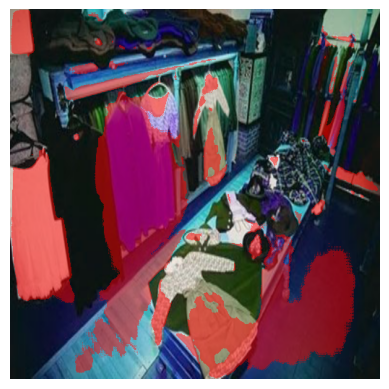

In [52]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

original_img_path = casia_data.loc[2, 'image_path']

# Open the original image using OpenCV
original_img = cv2.imread(original_img_path)

# Resize the original image using OpenCV
original_img = cv2.resize(original_img, (512, 512))

# Assume `pred_region` is a binary mask
mask_img = pred_region

# Create an RGBA version of the original image
original_array_rgba = np.concatenate([original_img, np.full(original_img.shape[:-1] + (1,), 255, dtype=np.uint8)], axis=-1)

# Prepare a red semi-transparent overlay
overlay = np.zeros(original_array_rgba.shape, dtype=np.uint8)
red_color = [255, 0, 0, 128]  # Semi-transparent red

# Apply the red overlay where the mask is black
overlay[mask_img == 1] = red_color

# Convert the numpy arrays back to PIL image for alpha compositing
original_img_rgba = Image.fromarray(original_array_rgba)
overlay_img = Image.fromarray(overlay)

# Composite the images together
highlighted_img = Image.alpha_composite(original_img_rgba, overlay_img)

# Convert back to RGB to save in JPG format
highlighted_img_rgb = highlighted_img.convert("RGB")


# Display the highlighted image
plt.imshow(highlighted_img_rgb)
plt.axis('off')  # Turn off the axis
plt.show()
